In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [21]:
def load_data(path):
  return pd.read_csv(path)

def filter_columns(data, year):
  if year <= 2022:
    data['Option 1'] = pd.to_numeric(data['Answered 1'].str.replace(r'%', ''))
    data['Option 2'] = pd.to_numeric(data['Answered 2'].str.replace(r'%', ''))
    data['Option 3'] = pd.to_numeric(data['Answered 3'].str.replace(r'%', ''))
    data['Option 4'] = pd.to_numeric(data['Answered 4'].str.replace(r'%', ''))
    data['Option 5'] = pd.to_numeric(data['Answered 5'].str.replace(r'%', ''))
    data.rename(columns={'Sample Size': 'Population',
                         'Question Number': 'Question Num',
                         'Provider': 'Provider name',
                         'Subject Code': 'Subject code',
                         'Response': 'Responses',
                        #  'Answered 1': 'Option 5',
                        #  'Answered 2': 'Option 4',
                        #  'Answered 3': 'Option 3',
                        #  'Answered 4': 'Option 2',
                        #  'Answered 5': 'Option 1',
                         'Actual value': 'Positivity'}, inplace=True)
  else:
    data.rename(columns={'Positivity measure (%)': 'Positivity', 'Publication response rate (%)': 'Response Rate', 'Question':'Question Num'}, inplace=True)
    data.loc[:, 'Option 1'] = round((data['Option 1'] / data['Responses']) * 100, 1)
    data.loc[:, 'Option 2'] = round((data['Option 2'] / data['Responses']) * 100, 1)
    data.loc[:, 'Option 3'] = round((data['Option 3'] / data['Responses']) * 100, 1)
    data.loc[:, 'Option 4'] = round((data['Option 4'] / data['Responses']) * 100, 1)
  data = data[['UKPRN', 'Provider name', 'Subject code', 'Subject', 'Question Num', 'Responses', 'Population',
  'Option 1', 'Option 2', 'Option 3', 'Option 4', 'Option 5', 'Positivity']]
  
  return data

def drop_theme_rows(data, year):
  if year <= 2022:
    term = 'Scale'
    col_name = 'Question Num'
  else:
    term = 'Theme'
    col_name = 'Question Num'
  theme_df = data[data[col_name].str.contains(term)]
  theme_indices = list(theme_df.index.values) 
  data = data[~data.index.isin(theme_indices)]
  hc_df = data[data[col_name].str.contains('HC')]
  hc_indices = list(hc_df.index.values) 
  data = data[~data.index.isin(hc_indices)]
  return data

# get first 3 characters of the string - Q01, Q27
def get_qn_num(data, year):
  if year > 2022:
    data[['Question Num', 'Question']] = data['Question Num'].str.split(':', expand=True)
  # else:
  #   data.rename(columns={'Question', 'Question Num'})
  return data

def drop_null_surveys(data):
  null_prn = list(data[(data['Option 1'].isna())]['UKPRN'].unique())
  null_course = list(data[(data['Option 1'].isna())]['Subject code'].unique())
  if len(null_prn) == len(null_course):
    for i in range(len(null_prn)):
      data = data[~((data['UKPRN'] == null_prn[i]) & (data['Subject code'] == null_course[i]))]
  return data

In [22]:
def get_index_col(data):
  data.index = np.arange(1, len(data) + 1)
  data['index1'] = data.index
  return data  

def get_qn27_data(data):
  q27_rows = data[data['Question Num'] == 'Q27']['index1'].values.tolist()
  with_27qn = pd.DataFrame(columns=list(data.columns))
  for i in range(len(q27_rows)):
    new_data_27 = data.iloc[q27_rows[i]-27:q27_rows[i]]
    with_27qn = pd.concat([with_27qn, new_data_27], ignore_index=True)
  return with_27qn

def get_qn28_data(data):
  q28_rows = data[data['Question Num'] == 'Q28']['index1'].values.tolist()
  with_28qn = pd.DataFrame(columns=list(data.columns))
  for i in range(len(q28_rows)):
    new_data_28 = data.iloc[q28_rows[i]-27:q28_rows[i]]
    with_28qn = pd.concat([with_28qn, new_data_28], ignore_index=True)
  return with_28qn

def generate_subsets(data):
  data = get_index_col(data)
  english_final = get_qn27_data(data)
  not_english_final = get_qn28_data(data)
  drop_rows_1 = not_english_final['index1'].values.tolist()
  drop_rows_2 = english_final['index1'].values.tolist()
  uk_final = data.copy()
  uk_final = data[~(data['index1'].isin(drop_rows_1))]
  uk_final = uk_final[~(uk_final['index1'].isin(drop_rows_2))]
  return english_final, not_english_final, uk_final

In [24]:
path = '../data/2023/NSS3_2023.csv'
# path = '../data/2023/not_english_.csv'
# path = '../data/2022/level_3.csv'
year = int(path.split('/')[1])

def pipeline(*funcs):
    def inner(data):
        result = data
        for func in funcs:
            result = func(result)
        return result
    return inner

data_pipeline = pipeline(
    lambda x: load_data(x),
    lambda x: filter_columns(x, year),
    lambda x: drop_theme_rows(x, year),
    lambda x: get_qn_num(x, year),
    lambda x: drop_null_surveys(x)
)

df = data_pipeline(path)
df.head()

C:\Users\pm_\AppData\Local\Temp\ipykernel_22516\4023062186.py:2: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


,UKPRN,Provider name,Subject code,Subject,Question Num,Responses,Population,Option 1,Option 2,Option 3,Option 4,Option 5,Positivity,Question
0,UK,UK,CAH01-01-01,Medical sciences (non-specific),Q01,226.8,296.1,26.8,64.4,8.1,0.7,NaN,91.3,How good are teaching staff at explaining thi...
1,UK,UK,CAH01-01-01,Medical sciences (non-specific),Q02,226.8,296.1,15.4,63.6,18.5,2.4,NaN,79.1,How often do teaching staff make the subject ...
2,UK,UK,CAH01-01-01,Medical sciences (non-specific),Q03,226.5,296.1,44.7,43.5,11.0,0.9,NaN,88.2,How often is the course intellectually stimul...
3,UK,UK,CAH01-01-01,Medical sciences (non-specific),Q04,226.8,296.1,43.0,43.6,12.5,0.9,NaN,86.6,How often does your course challenge you to a...
4,UK,UK,CAH01-01-01,Medical sciences (non-specific),Q05,225.8,296.1,37.0,51.5,10.9,0.7,NaN,88.5,To what extent have you had the chance to exp...


In [25]:
eng_df, noteng_df, uk_df = generate_subsets(df)

C:\Users\pm_\AppData\Local\Temp\ipykernel_22516\551384533.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  with_27qn = pd.concat([with_27qn, new_data_27], ignore_index=True)
C:\Users\pm_\AppData\Local\Temp\ipykernel_22516\551384533.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  with_28qn = pd.concat([with_28qn, new_data_28], ignore_index=True)


In [26]:
df = noteng_df.copy()

In [27]:
df['Question Num'].unique()

array(['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09',
       'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18',
       'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q28'],
      dtype=object)

In [28]:
def get_processed_data(data, year):
  sample = data.copy()
  # sample = data[['Responses', 'Option 1', 'Option 2', 'Option 3', 'Option 4', 'Option 5', 'Positivity', 'Question Num']]
  # sample = sample[['Responses', 'Option 1', 'Option 2', 'Option 3', 'Option 4', 'Positivity', 'Question Num', 'Region']]
  sample = sample[['Responses', 'Option 1', 'Option 2', 'Option 3', 'Option 4', 'Option 5', 'Positivity', 'Question Num']]
  if year <= 2022:
    sample.loc[:, 'Opt-1'] = sample['Option 5']
    sample.loc[:, 'Opt-2'] = sample['Option 4']
    sample.loc[:, 'Opt-3'] = sample['Option 2']
    sample.loc[:, 'Opt-4'] = sample['Option 1']
      # sample.loc[:, 'Opt-1'] = round((sample['Option 5'] / sample['Responses']) * 100, 1)
      # sample.loc[:, 'Opt-2'] = round((sample['Option 4'] / sample['Responses']) * 100, 1)
      # sample.loc[:, 'Opt-3'] = round((sample['Option 2'] / sample['Responses']) * 100, 1)
      # sample.loc[:, 'Opt-4'] = round((sample['Option 1'] / sample['Responses']) * 100, 1)
  else:
    sample.loc[:, 'Opt-1'] = sample['Option 1']
    sample.loc[:, 'Opt-2'] = sample['Option 2']
    sample.loc[:, 'Opt-3'] = sample['Option 3']
    sample.loc[:, 'Opt-4'] = sample['Option 4']
  only_options = sample[['Question Num', 'Opt-1', 'Opt-2', 'Opt-3', 'Opt-4']]
  # region_false = ''
  # if region == 'English': region_false = 'R_Non-English'
  # else: region_false = 'R_English'
  # only_options[region] = [region]*len(only_options['Opt-1'])
  only_options = only_options.copy()
  only_options.loc[:, 'Positivity'] = only_options['Opt-1'] + only_options['Opt-2']
  # data_2 = pd.get_dummies(only_options, prefix=['N'], dtype=float)
  # data_2[region_false] = [0.0]*len(data_2)
  return only_options

In [29]:
sample = get_processed_data(df, year)
sample.head()

,Question Num,Opt-1,Opt-2,Opt-3,Opt-4,Positivity
0,Q01,25.0,64.8,7.6,2.5,89.8
1,Q02,20.8,62.7,14.4,2.1,83.5
2,Q03,64.4,32.6,2.5,0.4,97.0
3,Q04,46.2,42.4,10.6,0.8,88.6
4,Q05,39.3,46.2,12.4,2.1,85.5


In [30]:
sample.shape

(78111, 6)

In [31]:
sample['Question Num'].value_counts()

Question Num
Q01    2893
Q15    2893
Q26    2893
Q25    2893
Q24    2893
Q23    2893
Q22    2893
Q21    2893
Q20    2893
Q19    2893
Q18    2893
Q17    2893
Q16    2893
Q14    2893
Q02    2893
Q13    2893
Q12    2893
Q11    2893
Q10    2893
Q09    2893
Q08    2893
Q07    2893
Q06    2893
Q05    2893
Q04    2893
Q03    2893
Q28    2893
Name: count, dtype: int64

In [32]:
only_options = sample[['Opt-1', 'Opt-2', 'Opt-3', 'Opt-4', 'Positivity']]
only_options.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78111 entries, 0 to 78110
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Opt-1       78111 non-null  float64
 1   Opt-2       78111 non-null  float64
 2   Opt-3       78111 non-null  float64
 3   Opt-4       78111 non-null  float64
 4   Positivity  78111 non-null  float64
dtypes: float64(5)
memory usage: 3.0 MB


In [33]:
only_options.head()

,Opt-1,Opt-2,Opt-3,Opt-4,Positivity
0,25.0,64.8,7.6,2.5,89.8
1,20.8,62.7,14.4,2.1,83.5
2,64.4,32.6,2.5,0.4,97.0
3,46.2,42.4,10.6,0.8,88.6
4,39.3,46.2,12.4,2.1,85.5


In [34]:
only_options.describe()

,Opt-1,Opt-2,Opt-3,Opt-4,Positivity
count,78111.000000,78111.000000,78111.000000,78111.000000,78111.000000
mean,33.653173,46.560266,15.321929,4.334514,80.213439
std,16.058440,12.312469,10.236765,5.725715,13.618605
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.100000,39.000000,8.100000,0.000000,73.100000
50%,32.100000,46.700000,14.000000,2.600000,82.400000
75%,43.500000,54.400000,20.800000,6.400000,90.000000
max,100.000000,100.400000,80.000000,84.600000,101.100000


In [35]:
only_options.sort_values(by='Positivity', axis=0, ascending=False)

,Opt-1,Opt-2,Opt-3,Opt-4,Positivity
40645,57.8,43.3,0.0,0.0,101.1
40699,57.8,43.3,0.0,0.0,101.1
20256,46.7,54.3,0.0,0.0,101.0
20255,51.0,50.0,0.0,0.0,101.0
20250,42.3,58.7,0.0,0.0,101.0
...,...,...,...,...,...
64062,0.0,0.0,50.0,50.0,0.0
19780,0.0,0.0,30.0,70.0,0.0
44724,0.0,0.0,60.0,40.0,0.0
62334,0.0,0.0,50.0,50.0,0.0


In [52]:
num_rows = 27
num_sets = len(only_options) // num_rows  # Calculate the number of sets
reshaped_data = only_options.values.reshape(num_sets, num_rows, 5)

# Split into training and test sets
train_data = reshaped_data[:, :26, :4]  # First 26 rows of each set as training data
test_data = reshaped_data[:, 26, :4]    # 27th row of each set as test data

X = reshaped_data[:, :26, :4]
y = reshaped_data[:, 26, :4]

X = X.reshape(-1, 26 * 4)
y = y.reshape(-1, 4)

In [53]:
print(X.shape)
print(y.shape)

(2893, 104)
(2893, 4)


In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

In [56]:
model_new = Sequential()
model_new.add(Dense(128, input_dim=26*4, activation='relu'))
model_new.add(Dense(128, activation='relu'))
model_new.add(BatchNormalization())
model_new.add(Dropout(0.2))
model_new.add(Dense(64, activation='relu'))
model_new.add(BatchNormalization())
model_new.add(Dropout(0.2))
model_new.add(Dense(64, activation='relu'))
model_new.add(BatchNormalization())
model_new.add(Dropout(0.2))
# model_new.add(Dense(32, activation='relu'))
model_new.add(Dense(16, activation='relu'))
model_new.add(Dense(4))

# Compile the model
model_new.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_new = model_new.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss_new = model_new.evaluate(X_test, y_test)
print("Test Loss:", loss_new)

c:\user_exe\00_Leeds\Dissertation\project-files\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 929.1791 - val_loss: 835.9346
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 710.5012 - val_loss: 428.6167
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 335.9726 - val_loss: 166.8377
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 142.7526 - val_loss: 89.8798
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.3424 - val_loss: 72.6828
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79.9246 - val_loss: 58.6341
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 76.0409 - val_loss: 54.3327
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70.4394 - val_loss: 51.4615
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69.8061 - val_loss: 47.9838
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.0387 - val_loss: 45.2403
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.3624 - val_loss: 80.5963
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━

In [57]:
sample_input = X_test[0].reshape(1, -1)
predicted_output = model_new.predict(sample_input)
predicted_output = np.round(predicted_output, 1)
print("Sample Input:", X_test[0])
print("Input Shape:", X_test[0].shape)
print("Predicted Output:", predicted_output[0])
print("Actual Output:", y_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Sample Input: [78.3 21.7  0.   0.  52.2 47.8  0.   0.  69.6 30.4  0.   0.  69.6 30.4
  0.   0.  60.9 26.1 13.   0.  69.6 30.4  0.   0.  60.9 34.8  4.3  0.
 69.6 26.1  4.3  0.  73.9 26.1  0.   0.  56.5 39.1  4.3  0.  56.5 43.5
  0.   0.  43.5 56.5  0.   0.  47.8 39.1 13.   0.  60.9 39.1  0.   0.
 65.2 34.8  0.   0.  69.6 30.4  0.   0.  65.2 34.8  0.   0.  59.1 40.9
  0.   0.  68.2 31.8  0.   0.  82.6 17.4  0.   0.  61.1 33.3  5.6  0.
 69.6 30.4  0.   0.  65.2 34.8  0.   0.  31.8 45.5 22.7  0.  31.6 52.6
 15.8  0.  73.9 26.1  0.   0. ]
Input Shape: (104,)
Predicted Output: [77.8 21.2  1.9  1.8]
Actual Output: [78.3 21.7  0.   0. ]


In [58]:
sample_input = X_test[10].reshape(1, -1)
predicted_output = model_new.predict(sample_input)
predicted_output = np.round(predicted_output, 1)
print("Sample Input:", X_test[10])
print("Input Shape:", X_test[10].shape)
print("Predicted Output:", predicted_output[0])
print("Actual Output:", y_test[10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sample Input: [16.7 66.7 16.7  0.  11.1 61.1 16.7 11.1 27.8 44.4 22.2  5.6 38.9 22.2
 38.9  0.  16.7 33.3 44.4  5.6 27.8 38.9 33.3  0.  11.1 27.8 50.  11.1
 22.2 27.8 38.9 11.1 22.2 27.8 38.9 11.1 22.2 33.3 44.4  0.  41.2 35.3
 17.6  5.9 27.8 33.3 33.3  5.6 11.1 44.4 27.8 16.7 11.1 44.4 33.3 11.1
 16.7 22.2 44.4 16.7 22.2 44.4 16.7 16.7  5.6 38.9 38.9 16.7 25.  31.2
 31.2 12.5 41.2 41.2 17.6  0.   7.1 64.3  7.1 21.4 35.3 41.2 17.6  5.9
 17.6 47.1 17.6 17.6 11.8 29.4 35.3 23.5  0.  23.5 47.1 29.4  0.  46.2
 30.8 23.1 22.2 38.9 16.7 22.2]
Input Shape: (104,)
Predicted Output: [ 8.7 36.8 23.8 16.6]
Actual Output: [11.1 33.3 16.7 22.2]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Absolute Error (MAE) - Train: 3.56082180176597
Mean Squared Error (MSE) - Train: 21.765404465607496
R² Score - Train: 0.7101138734072734


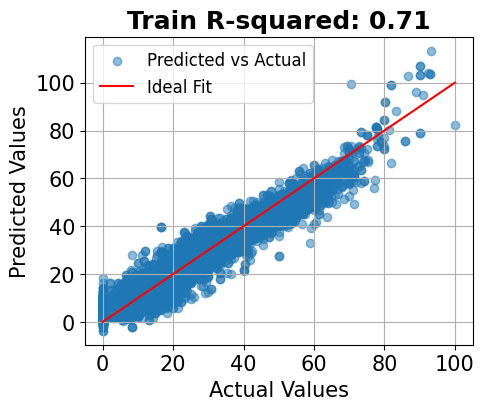

Mean Absolute Error (MAE) - Test: 4.050374056869838
Mean Squared Error (MSE) - Test: 30.192274783235703
R² Score - Test: 0.6427754424141972


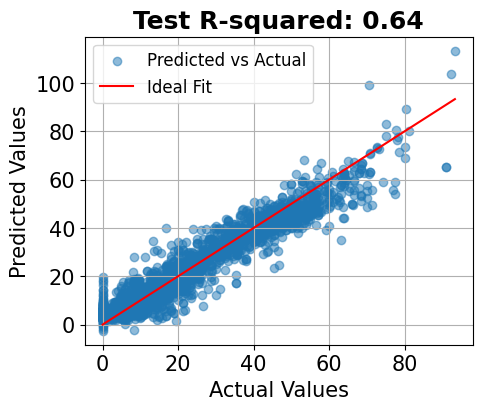

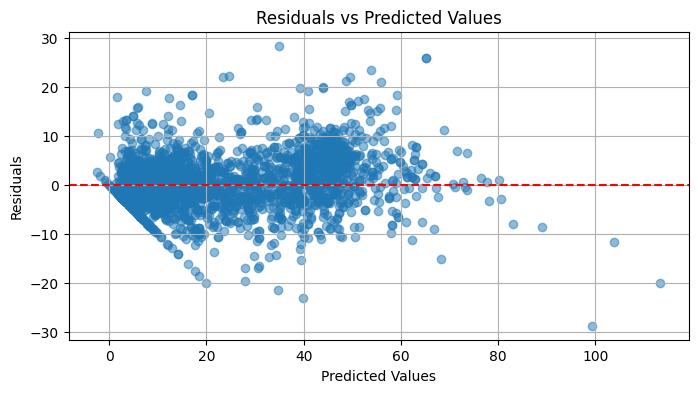

In [59]:
# Predictions
predictions = model_new.predict(X_test)
predictions_train = model_new.predict(X_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Performance metrics for training data
mae_train = mean_absolute_error(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

# Print performance metrics for training data
print(f"Mean Absolute Error (MAE) - Train: {mae_train}")
print(f"Mean Squared Error (MSE) - Train: {mse_train}")
print(f"R² Score - Train: {r2_train}")

# Plot actual vs predicted values for training data
plt.figure(figsize=(5, 4))
plt.scatter(y_train, predictions_train, alpha=0.5, label='Predicted vs Actual')
plt.plot([np.min(y_train), np.max(y_train)], [np.min(y_train), np.max(y_train)], color='red', label='Ideal Fit')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title(f'Train R-squared: {round(r2_train, 2)}', fontsize=18, weight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Performance metrics for test data
mae_test = mean_absolute_error(y_test, predictions)
mse_test = mean_squared_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)

# Print performance metrics for test data
print(f"Mean Absolute Error (MAE) - Test: {mae_test}")
print(f"Mean Squared Error (MSE) - Test: {mse_test}")
print(f"R² Score - Test: {r2_test}")

# Plot actual vs predicted values for test data
plt.figure(figsize=(5, 4))
plt.scatter(y_test, predictions, alpha=0.5, label='Predicted vs Actual')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', label='Ideal Fit')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title(f'Test R-squared: {round(r2_test, 2)}', fontsize=18, weight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - predictions
plt.figure(figsize=(8, 4))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

dict_keys(['loss', 'val_loss'])


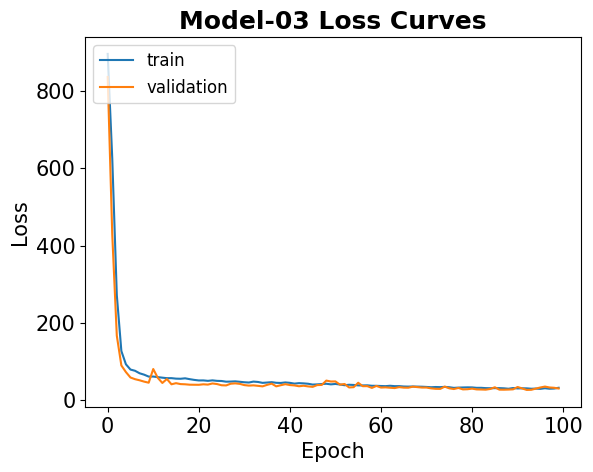

In [60]:
print(history_new.history.keys())
# summarize history for loss
plt.plot(history_new.history['loss'])
plt.plot(history_new.history['val_loss'])
plt.title('Model-03 Loss Curves', fontsize=18, weight='bold')
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

In [61]:
sample_input = X_test[19].reshape(1, -1)
predicted_output = model_new.predict(sample_input)
predicted_output = np.round(predicted_output, 1)
print("Predicted Output:", predicted_output[0])
print("Actual Output:", y_test[19])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Output: [53.4 30.7  7.9  4.8]
Actual Output: [54.  36.7  8.4  0.4]


In [62]:
# Predictions
predictions = model_new.predict(X_test)
predictions_train = model_new.predict(X_train)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [63]:
predictions_rounded = np.round(predictions, 1)
sum_predicted = np.sum(predictions_rounded[:, :2], axis=1)
test_predictions_df = pd.DataFrame(predictions_rounded, columns=[f'Test_Pred_{i}' for i in range(predictions_rounded.shape[1])])
test_predictions_df['Test_Pred'] = sum_predicted
test_predictions_df = test_predictions_df.astype('float')
test_predictions_df = test_predictions_df.round(1)

sum_predicted = np.sum(y_test[:, :2], axis=1)
test_actual_df = pd.DataFrame(y_test, columns=[f'Test_Actual_{i}' for i in range(y_test.shape[1])])
test_actual_df['Test_Actual'] = sum_predicted

In [64]:
predictions_rounded = np.round(predictions_train, 1)
sum_predicted = np.sum(predictions_rounded[:, :2], axis=1)
train_predictions_df = pd.DataFrame(predictions_rounded, columns=[f'Train_Pred_{i}' for i in range(predictions_rounded.shape[1])])
train_predictions_df['Train_Pred'] = sum_predicted
train_predictions_df = train_predictions_df.astype('float')
train_predictions_df = train_predictions_df.round(1)

sum_predicted = np.sum(y_train[:, :2], axis=1)
train_actual_df = pd.DataFrame(y_train, columns=[f'Train_Actual_{i}' for i in range(y_train.shape[1])])
train_actual_df['Train_Actual'] = sum_predicted

In [65]:
test_compare = pd.DataFrame()
test_compare['Pred'] = test_predictions_df['Test_Pred']
test_compare['Actual'] = test_actual_df['Test_Actual']
test_compare['Pred_0'] = test_predictions_df['Test_Pred_0']
test_compare['Actual_0'] = test_actual_df['Test_Actual_0']
test_compare['Pred_1'] = test_predictions_df['Test_Pred_1']
test_compare['Actual_1'] = test_actual_df['Test_Actual_1']
test_compare['Pos_Diff'] = test_compare['Pred'] - test_compare['Actual']
test_compare['0_Diff'] = test_compare['Pred_0'] - test_compare['Actual_0']
test_compare['1_Diff'] = test_compare['Pred_1'] - test_compare['Actual_1']

train_compare = pd.DataFrame()
train_compare['Pred'] = train_predictions_df['Train_Pred']
train_compare['Actual'] = train_actual_df['Train_Actual']
train_compare['Pred_0'] = train_predictions_df['Train_Pred_0']
train_compare['Actual_0'] = train_actual_df['Train_Actual_0']
train_compare['Pred_1'] = train_predictions_df['Train_Pred_1']
train_compare['Actual_1'] = train_actual_df['Train_Actual_1']
train_compare['Pos_Diff'] = train_compare['Pred'] - train_compare['Actual']
train_compare['0_Diff'] = train_compare['Pred_0'] - train_compare['Actual_0']
train_compare['1_Diff'] = train_compare['Pred_1'] - train_compare['Actual_1']

In [66]:
test_compare.describe().iloc[1][6:]

Pos_Diff   -3.403109
0_Diff     -0.753195
1_Diff     -2.649914
Name: mean, dtype: float64

In [67]:
train_compare.describe().iloc[1][6:]

Pos_Diff   -3.213440
0_Diff     -1.077442
1_Diff     -2.135998
Name: mean, dtype: float64